In [589]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [590]:
df = pd.read_csv('building_solar_values.csv')
df = df.iloc[:, 1:]
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-04 07:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-04 07:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-04 08:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04 08:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-04 08:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151781,2020-11-01 08:45:00,105.0,8.4,322.0,1.0,NaN,26.4,18.53,4.96,4.73,4.31,2.84,13.47
151782,2020-11-01 09:00:00,105.0,11.3,322.0,NaN,NaN,26.6,22.23,5.88,5.64,5.08,3.40,15.93
151783,2020-11-01 09:15:00,77.6,2.3,327.0,NaN,NaN,26.6,23.39,6.31,5.99,5.45,3.62,17.11
151784,2020-11-01 09:30:00,77.6,5.1,327.0,1.0,NaN,27.4,24.56,6.73,6.35,5.83,3.85,18.29


In [591]:
df = df.drop(columns=['Building0','Building1','Building3','Building4','Building5','Building6'])
df

,Date,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-04 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-04 07:45:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-04 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-04 08:30:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
151781,2020-11-01 08:45:00,18.53,4.96,4.73,4.31,2.84,13.47
151782,2020-11-01 09:00:00,22.23,5.88,5.64,5.08,3.40,15.93
151783,2020-11-01 09:15:00,23.39,6.31,5.99,5.45,3.62,17.11
151784,2020-11-01 09:30:00,24.56,6.73,6.35,5.83,3.85,18.29


# Solar 0

In [592]:
Solar0 = df.drop(columns=['Solar1','Solar2','Solar3','Solar4','Solar5'])
Solar0

,Date,Solar0
0,2016-07-04 07:30:00,NaN
1,2016-07-04 07:45:00,NaN
2,2016-07-04 08:00:00,NaN
3,2016-07-04 08:15:00,NaN
4,2016-07-04 08:30:00,NaN
...,...,...
151781,2020-11-01 08:45:00,18.53
151782,2020-11-01 09:00:00,22.23
151783,2020-11-01 09:15:00,23.39
151784,2020-11-01 09:30:00,24.56


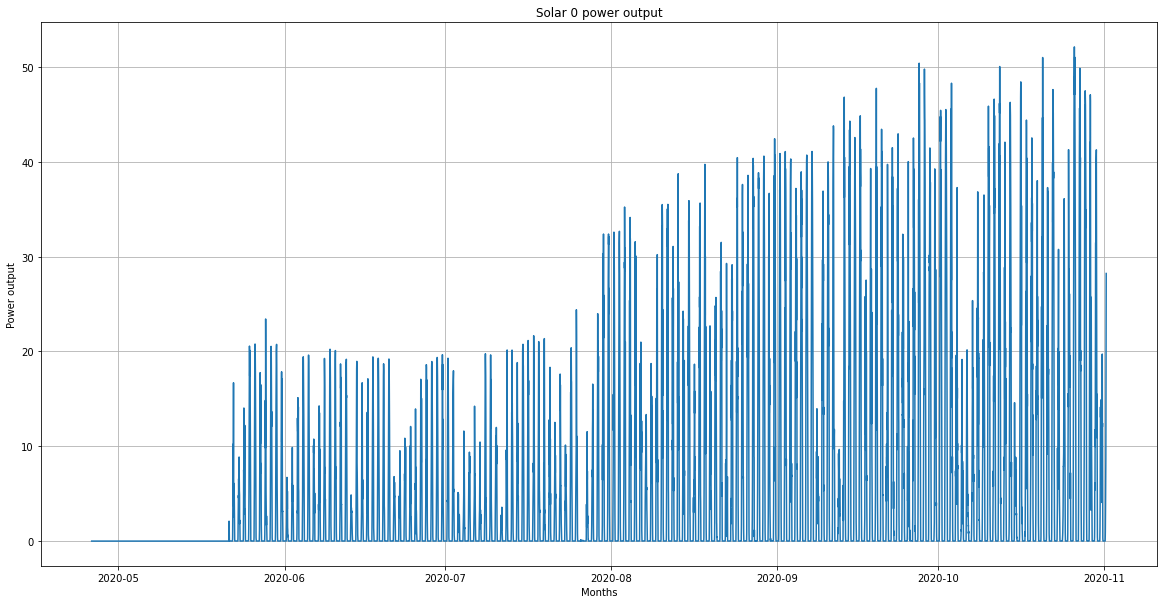

In [593]:
plt.figure(figsize=(20, 10))
plt.plot(Solar0['Date'], Solar0['Solar0'])
plt.xlabel('Months')
plt.ylabel('Power output')
plt.title('Solar 0 power output')
plt.grid(True)
plt.show()

In [594]:
Solar0.set_index('Date', inplace=True)
s = Solar0.index > '2020-05-31 23:45:00'
t = Solar0.index < '2020-11-01 00:00:00'
Solar0 = Solar0[s&t]
Solar0

,Solar0
Date,
2020-06-01 00:00:00,0.01
2020-06-01 00:15:00,0.01
2020-06-01 00:30:00,0.01
2020-06-01 00:45:00,0.01
2020-06-01 01:00:00,0.01
...,...
2020-10-31 22:45:00,0.01
2020-10-31 23:00:00,0.01
2020-10-31 23:15:00,0.01


In [595]:
weather = pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
s = weather.index > '2020-05-31 23:45:00'
weather = weather[s]
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2020-06-01 00:00:00,11.200,8.000,5.90,100652.600,0.800,0.000,309.400,0.2
2020-06-01 00:15:00,11.200,7.975,6.00,100626.100,0.800,0.000,309.625,0.3
2020-06-01 00:30:00,11.200,7.950,6.10,100599.600,0.800,0.000,309.850,0.4
2020-06-01 00:45:00,11.200,7.925,6.20,100573.100,0.800,0.000,310.075,0.5
2020-06-01 01:00:00,11.200,7.900,6.30,100546.600,0.800,0.000,310.300,0.6
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.60,102077.100,0.700,80.500,296.200,1.0
2021-06-01 09:15:00,10.025,3.975,5.55,102085.225,0.675,97.825,298.500,1.0
2021-06-01 09:30:00,10.250,4.050,5.50,102093.350,0.650,115.150,300.800,1.0


In [596]:
nov_data = pd.read_csv('NOV_test_data.csv')
nov_data = nov_data.iloc[:, 1:]
nov_data['Date'] = pd.to_datetime(nov_data['Date'])
nov_data = nov_data.drop(columns=['Building0','Building1','Building3','Building4','Building5','Building6','Solar5','Solar1','Solar2','Solar3','Solar4'])
nov_data.set_index('Date', inplace=True)
t = nov_data.index < '2020-12-01 00:00:00'
nov_data = nov_data[t]
nov_data

,Solar0
Date,
2020-11-01 10:00:00,31.90
2020-11-01 10:15:00,32.02
2020-11-01 10:30:00,32.14
2020-11-01 10:45:00,36.68
2020-11-01 11:00:00,41.22
...,...
2020-11-30 22:45:00,0.01
2020-11-30 23:00:00,0.01
2020-11-30 23:15:00,0.01


# Y-train

In [597]:
#power output data from 2020/06/01 - 2020-10-31

Solar0

,Solar0
Date,
2020-06-01 00:00:00,0.01
2020-06-01 00:15:00,0.01
2020-06-01 00:30:00,0.01
2020-06-01 00:45:00,0.01
2020-06-01 01:00:00,0.01
...,...
2020-10-31 22:45:00,0.01
2020-10-31 23:00:00,0.01
2020-10-31 23:15:00,0.01


# Y - test

In [598]:
#power output data from 2020/11/01 - 2020-11-30

nov_data

,Solar0
Date,
2020-11-01 10:00:00,31.90
2020-11-01 10:15:00,32.02
2020-11-01 10:30:00,32.14
2020-11-01 10:45:00,36.68
2020-11-01 11:00:00,41.22
...,...
2020-11-30 22:45:00,0.01
2020-11-30 23:00:00,0.01
2020-11-30 23:15:00,0.01


# X - train

In [599]:
'''
* Surface  Thermal Radiation
* Surface Solar Radiation
* MSLP
* Dew Point Temperature
* Air Temperature
'''

t = weather.index < '2020-11-01 00:00:00'
weather_train = weather[t]
weather_train = weather_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_train

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2020-06-01 00:00:00,309.400,0.0,100652.600,8.000,11.20
2020-06-01 00:15:00,309.625,0.0,100626.100,7.975,11.20
2020-06-01 00:30:00,309.850,0.0,100599.600,7.950,11.20
2020-06-01 00:45:00,310.075,0.0,100573.100,7.925,11.20
2020-06-01 01:00:00,310.300,0.0,100546.600,7.900,11.20
...,...,...,...,...,...
2020-10-31 22:45:00,336.375,0.0,101948.875,9.375,12.05
2020-10-31 23:00:00,332.000,0.0,101948.000,9.300,12.00
2020-10-31 23:15:00,330.850,0.0,101959.000,9.250,11.95


# X - test

In [600]:
s = weather.index >= '2020-11-01 10:00:00'
t = weather.index < '2020-12-01 00:00:00'
weather_test = weather[s&t]
weather_test = weather_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_test

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2020-11-01 10:00:00,355.400,497.60,102398.800,9.300,14.400
2020-11-01 10:15:00,353.825,544.05,102398.025,9.400,14.750
2020-11-01 10:30:00,352.250,590.50,102397.250,9.500,15.100
2020-11-01 10:45:00,350.675,636.95,102396.475,9.600,15.450
2020-11-01 11:00:00,349.100,683.40,102395.700,9.700,15.800
...,...,...,...,...,...
2020-11-30 22:45:00,357.950,0.00,100671.375,15.575,18.875
2020-11-30 23:00:00,357.300,0.00,100667.600,15.600,18.700
2020-11-30 23:15:00,356.000,0.00,100633.300,15.550,18.625


In [601]:
X_train = weather_train
X_train = (X_train-X_train.mean())/X_train.std()

In [602]:
X_test = weather_test
X_test = (X_test-X_test.mean())/X_test.std()

In [603]:
Y_train = Solar0['Solar0']
Y_test = nov_data['Solar0']

In [647]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specify the objective for regression
    n_estimators=200,  # Number of boosting rounds
    learning_rate=0.03,  # Learning rate (step size)
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Random seed for reproducibility
)

regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 112.49599334905308
R^2: 0.5779845466514895


In [605]:
results = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})
results

,Actual,Predicted
Date,,
2020-11-01 10:00:00,31.90,14.417469
2020-11-01 10:15:00,32.02,18.094620
2020-11-01 10:30:00,32.14,22.925173
2020-11-01 10:45:00,36.68,22.290436
2020-11-01 11:00:00,41.22,26.369400
...,...,...
2020-11-30 22:45:00,0.01,-0.185053
2020-11-30 23:00:00,0.01,-0.185053
2020-11-30 23:15:00,0.01,-0.185053


In [606]:
# print('X_train:',X_train.shape)
# print('X_test:',X_test.shape)
# print('Y_train:',Y_train.shape)
# print('Y_test:',Y_test.shape)

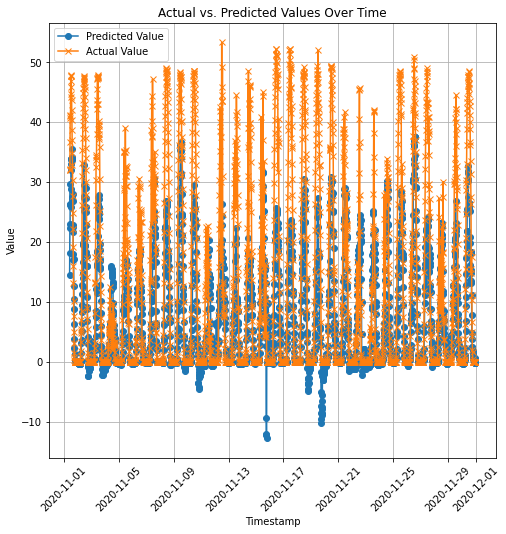

In [607]:
plt.figure(figsize=(8, 8))
plt.plot(results.index, results['Predicted'], label='Predicted Value', marker='o')
plt.plot(results.index, results['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Solar 1

In [608]:
Solar1 = df.drop(columns=['Solar0','Solar2','Solar3','Solar4','Solar5'])
Solar1

,Date,Solar1
0,2016-07-04 07:30:00,NaN
1,2016-07-04 07:45:00,NaN
2,2016-07-04 08:00:00,NaN
3,2016-07-04 08:15:00,NaN
4,2016-07-04 08:30:00,NaN
...,...,...
151781,2020-11-01 08:45:00,4.96
151782,2020-11-01 09:00:00,5.88
151783,2020-11-01 09:15:00,6.31
151784,2020-11-01 09:30:00,6.73


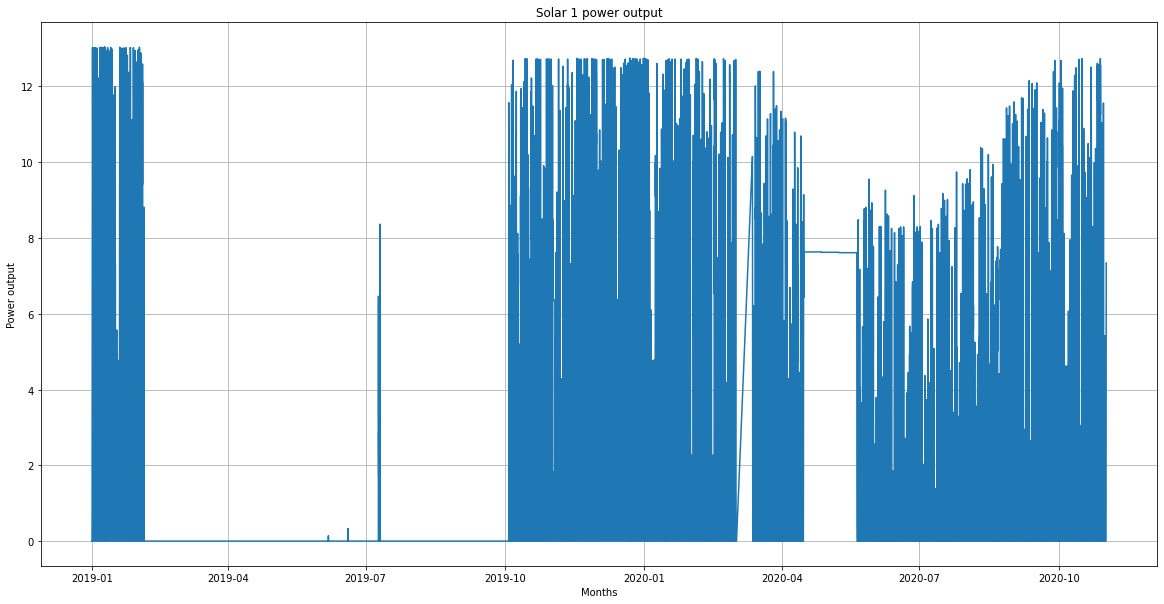

In [609]:
plt.figure(figsize=(20, 10))
plt.plot(Solar1['Date'], Solar1['Solar1'])
plt.xlabel('Months')
plt.ylabel('Power output')
plt.title('Solar 1 power output')
plt.grid(True)
plt.show()

In [610]:
Solar1.set_index('Date', inplace=True)
s = Solar1.index > '2019-09-30 23:49:00'
t = Solar1.index < '2020-11-01 00:00:00'
Solar1 = Solar1[s&t]
Solar1

,Solar1
Date,
2019-10-01 00:00:00,0.0
2019-10-01 00:15:00,0.0
2019-10-01 00:30:00,0.0
2019-10-01 00:45:00,0.0
2019-10-01 01:00:00,0.0
...,...
2020-10-31 22:45:00,0.0
2020-10-31 23:00:00,0.0
2020-10-31 23:15:00,0.0


In [611]:
weather = pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
s = weather.index > '2019-09-30 23:49:00'
weather1 = weather[s]
weather1

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2019-10-01 00:00:00,6.600,4.400,2.100,103031.800,0.900,0.000,260.300,0.1
2019-10-01 00:15:00,6.400,4.325,2.075,103022.500,0.900,0.000,260.025,0.1
2019-10-01 00:30:00,6.200,4.250,2.050,103013.200,0.900,0.000,259.750,0.1
2019-10-01 00:45:00,6.000,4.175,2.025,103003.900,0.900,0.000,259.475,0.1
2019-10-01 01:00:00,5.800,4.100,2.000,102994.600,0.900,0.000,259.200,0.1
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.200,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.500,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.800,1.0


In [612]:
nov_data = pd.read_csv('NOV_test_data.csv')
nov_data = nov_data.iloc[:, 1:]
nov_data['Date'] = pd.to_datetime(nov_data['Date'])
nov_data = nov_data.drop(columns=['Building0','Building1','Building3','Building4','Building5','Building6','Solar5','Solar0','Solar2','Solar3','Solar4'])
nov_data.set_index('Date', inplace=True)
t = nov_data.index < '2020-12-01 00:00:00'
nov_data1 = nov_data[t]
nov_data1

,Solar1
Date,
2020-11-01 10:00:00,7.95
2020-11-01 10:15:00,8.51
2020-11-01 10:30:00,9.07
2020-11-01 10:45:00,9.38
2020-11-01 11:00:00,9.68
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# Y - train (solar 1)

In [613]:
Solar1

,Solar1
Date,
2019-10-01 00:00:00,0.0
2019-10-01 00:15:00,0.0
2019-10-01 00:30:00,0.0
2019-10-01 00:45:00,0.0
2019-10-01 01:00:00,0.0
...,...
2020-10-31 22:45:00,0.0
2020-10-31 23:00:00,0.0
2020-10-31 23:15:00,0.0


# Y - test

In [614]:
nov_data1

,Solar1
Date,
2020-11-01 10:00:00,7.95
2020-11-01 10:15:00,8.51
2020-11-01 10:30:00,9.07
2020-11-01 10:45:00,9.38
2020-11-01 11:00:00,9.68
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# X - train

In [615]:
'''
* Surface  Thermal Radiation
* Surface Solar Radiation
* MSLP
* Dew Point Temperature
* Air Temperature
'''

t = weather1.index < '2020-11-01 00:00:00'
weather_train1 = weather1[t]
weather_train1 = weather_train1[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_train1

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2019-10-01 00:00:00,260.300,0.0,103031.800,4.400,6.60
2019-10-01 00:15:00,260.025,0.0,103022.500,4.325,6.40
2019-10-01 00:30:00,259.750,0.0,103013.200,4.250,6.20
2019-10-01 00:45:00,259.475,0.0,103003.900,4.175,6.00
2019-10-01 01:00:00,259.200,0.0,102994.600,4.100,5.80
...,...,...,...,...,...
2020-10-31 22:45:00,336.375,0.0,101948.875,9.375,12.05
2020-10-31 23:00:00,332.000,0.0,101948.000,9.300,12.00
2020-10-31 23:15:00,330.850,0.0,101959.000,9.250,11.95


In [616]:
s = weather1.index >= '2020-11-01 10:00:00'
t = weather1.index < '2020-12-01 00:00:00'
weather_test1 = weather1[s&t]
weather_test1 = weather_test1[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_test1

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2020-11-01 10:00:00,355.400,497.60,102398.800,9.300,14.400
2020-11-01 10:15:00,353.825,544.05,102398.025,9.400,14.750
2020-11-01 10:30:00,352.250,590.50,102397.250,9.500,15.100
2020-11-01 10:45:00,350.675,636.95,102396.475,9.600,15.450
2020-11-01 11:00:00,349.100,683.40,102395.700,9.700,15.800
...,...,...,...,...,...
2020-11-30 22:45:00,357.950,0.00,100671.375,15.575,18.875
2020-11-30 23:00:00,357.300,0.00,100667.600,15.600,18.700
2020-11-30 23:15:00,356.000,0.00,100633.300,15.550,18.625


In [617]:
X_train1 = weather_train1
X_train1 = (X_train1-X_train1.mean())/X_train1.std()

In [618]:
X_test1 = weather_test1
X_test1 = (X_test1-X_test1.mean())/X_test1.std()

In [619]:
Y_train1 = Solar1['Solar1']
Y_test1 = nov_data1['Solar1']

In [620]:
print('X_train:',X_train1.shape)
print('X_test:',X_test1.shape)
print('Y_train:',Y_train1.shape)
print('Y_test:',Y_test1.shape)

X_train: (38112, 5)
X_test: (2840, 5)
Y_train: (38112,)
Y_test: (2840,)


In [621]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specify the objective for regression
    n_estimators=300,  # Number of boosting rounds
    learning_rate=0.03,  # Learning rate (step size)
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Random seed for reproducibility
)

regressor.fit(X_train1, Y_train1)
predictions1 = regressor.predict(X_test1)

MSE = mean_squared_error(Y_test1, predictions1)
print("MSE:", MSE)

total = np.sum((Y_test1 - np.mean(Y_test1))**2)
residual = np.sum((Y_test1 - predictions1)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 3.928199939990407
R^2: 0.7862550539817026


In [622]:
results1 = pd.DataFrame({'Actual': Y_test1, 'Predicted': predictions1})
results1

,Actual,Predicted
Date,,
2020-11-01 10:00:00,7.95,6.184431
2020-11-01 10:15:00,8.51,6.378008
2020-11-01 10:30:00,9.07,6.789808
2020-11-01 10:45:00,9.38,7.208655
2020-11-01 11:00:00,9.68,7.327519
...,...,...
2020-11-30 22:45:00,0.00,0.593698
2020-11-30 23:00:00,0.00,0.581581
2020-11-30 23:15:00,0.00,0.534186


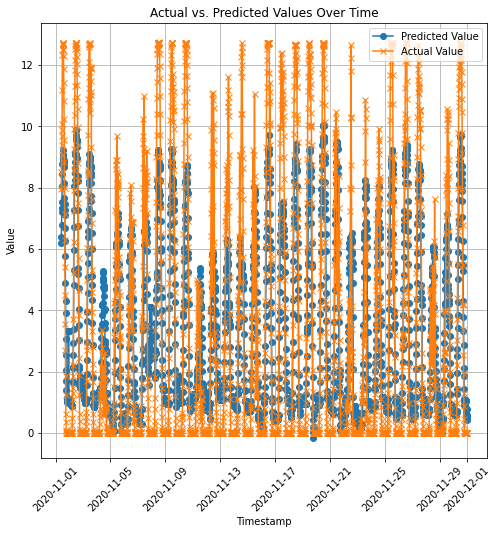

In [623]:
plt.figure(figsize=(8, 8))
plt.plot(results.index, results1['Predicted'], label='Predicted Value', marker='o')
plt.plot(results.index, results1['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Solar 2

In [624]:
Solar2 = df.drop(columns=['Solar0','Solar1','Solar3','Solar4','Solar5'])
Solar2

,Date,Solar2
0,2016-07-04 07:30:00,NaN
1,2016-07-04 07:45:00,NaN
2,2016-07-04 08:00:00,NaN
3,2016-07-04 08:15:00,NaN
4,2016-07-04 08:30:00,NaN
...,...,...
151781,2020-11-01 08:45:00,4.73
151782,2020-11-01 09:00:00,5.64
151783,2020-11-01 09:15:00,5.99
151784,2020-11-01 09:30:00,6.35


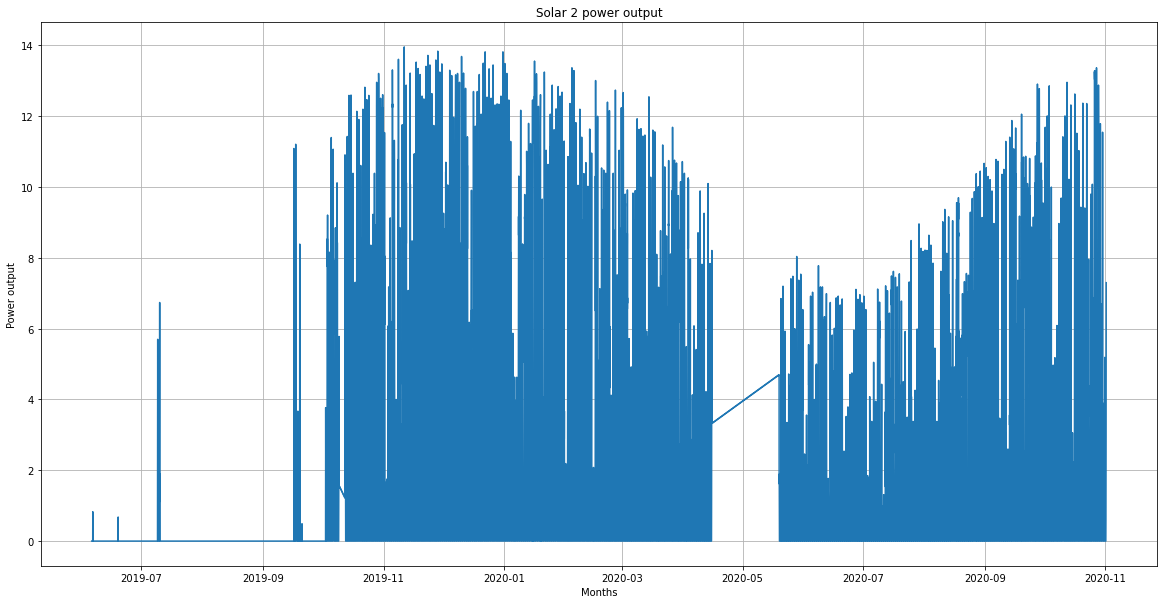

In [625]:
plt.figure(figsize=(20, 10))
plt.plot(Solar2['Date'], Solar2['Solar2'])
plt.xlabel('Months')
plt.ylabel('Power output')
plt.title('Solar 2 power output')
plt.grid(True)
plt.show()

In [626]:
Solar2.set_index('Date', inplace=True)
s = Solar2.index > '2019-09-30 23:49:00'
t = Solar2.index < '2020-11-01 00:00:00'
Solar2 = Solar2[s&t]
Solar2

,Solar2
Date,
2019-10-01 00:00:00,0.0
2019-10-01 00:15:00,0.0
2019-10-01 00:30:00,0.0
2019-10-01 00:45:00,0.0
2019-10-01 01:00:00,0.0
...,...
2020-10-31 22:45:00,0.0
2020-10-31 23:00:00,0.0
2020-10-31 23:15:00,0.0


In [627]:
weather = pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
s = weather.index > '2019-09-30 23:49:00'
weather2 = weather[s]
weather2

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2019-10-01 00:00:00,6.600,4.400,2.100,103031.800,0.900,0.000,260.300,0.1
2019-10-01 00:15:00,6.400,4.325,2.075,103022.500,0.900,0.000,260.025,0.1
2019-10-01 00:30:00,6.200,4.250,2.050,103013.200,0.900,0.000,259.750,0.1
2019-10-01 00:45:00,6.000,4.175,2.025,103003.900,0.900,0.000,259.475,0.1
2019-10-01 01:00:00,5.800,4.100,2.000,102994.600,0.900,0.000,259.200,0.1
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.200,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.500,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.800,1.0


In [628]:
nov_data = pd.read_csv('NOV_test_data.csv')
nov_data = nov_data.iloc[:, 1:]
nov_data['Date'] = pd.to_datetime(nov_data['Date'])
nov_data = nov_data.drop(columns=['Building0','Building1','Building3','Building4','Building5','Building6','Solar5','Solar0','Solar1','Solar3','Solar4'])
nov_data.set_index('Date', inplace=True)
t = nov_data.index < '2020-12-01 00:00:00'
nov_data2 = nov_data[t]
nov_data2

,Solar2
Date,
2020-11-01 10:00:00,8.26
2020-11-01 10:15:00,8.11
2020-11-01 10:30:00,7.95
2020-11-01 10:45:00,9.12
2020-11-01 11:00:00,10.29
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# Y - train (Solar 2)

In [629]:
Solar2

,Solar2
Date,
2019-10-01 00:00:00,0.0
2019-10-01 00:15:00,0.0
2019-10-01 00:30:00,0.0
2019-10-01 00:45:00,0.0
2019-10-01 01:00:00,0.0
...,...
2020-10-31 22:45:00,0.0
2020-10-31 23:00:00,0.0
2020-10-31 23:15:00,0.0


# Y - test

In [630]:
nov_data2

,Solar2
Date,
2020-11-01 10:00:00,8.26
2020-11-01 10:15:00,8.11
2020-11-01 10:30:00,7.95
2020-11-01 10:45:00,9.12
2020-11-01 11:00:00,10.29
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# X - train

In [631]:
'''
* Surface  Thermal Radiation
* Surface Solar Radiation
* MSLP
* Dew Point Temperature
* Air Temperature
'''

t = weather2.index < '2020-11-01 00:00:00'
weather_train2 = weather2[t]
weather_train2 = weather_train2[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_train2

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2019-10-01 00:00:00,260.300,0.0,103031.800,4.400,6.60
2019-10-01 00:15:00,260.025,0.0,103022.500,4.325,6.40
2019-10-01 00:30:00,259.750,0.0,103013.200,4.250,6.20
2019-10-01 00:45:00,259.475,0.0,103003.900,4.175,6.00
2019-10-01 01:00:00,259.200,0.0,102994.600,4.100,5.80
...,...,...,...,...,...
2020-10-31 22:45:00,336.375,0.0,101948.875,9.375,12.05
2020-10-31 23:00:00,332.000,0.0,101948.000,9.300,12.00
2020-10-31 23:15:00,330.850,0.0,101959.000,9.250,11.95


# X - test

In [632]:
s = weather2.index >= '2020-11-01 10:00:00'
t = weather2.index < '2020-12-01 00:00:00'
weather_test2 = weather2[s&t]
weather_test2 = weather_test2[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_test2

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2020-11-01 10:00:00,355.400,497.60,102398.800,9.300,14.400
2020-11-01 10:15:00,353.825,544.05,102398.025,9.400,14.750
2020-11-01 10:30:00,352.250,590.50,102397.250,9.500,15.100
2020-11-01 10:45:00,350.675,636.95,102396.475,9.600,15.450
2020-11-01 11:00:00,349.100,683.40,102395.700,9.700,15.800
...,...,...,...,...,...
2020-11-30 22:45:00,357.950,0.00,100671.375,15.575,18.875
2020-11-30 23:00:00,357.300,0.00,100667.600,15.600,18.700
2020-11-30 23:15:00,356.000,0.00,100633.300,15.550,18.625


In [633]:
X_train2 = weather_train2
X_train2 = (X_train2-X_train2.mean())/X_train2.std()

In [634]:
X_test2 = weather_test2
X_test2 = (X_test2-X_test2.mean())/X_test2.std()

In [635]:
Y_train2 = Solar2['Solar2']
Y_test2 = nov_data2['Solar2']

In [636]:
print('X_train:',X_train2.shape)
print('X_test:',X_test2.shape)
print('Y_train:',Y_train2.shape)
print('Y_test:',Y_test2.shape)

X_train: (38112, 5)
X_test: (2840, 5)
Y_train: (38112,)
Y_test: (2840,)


In [666]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specify the objective for regression
    n_estimators=300,  # Number of boosting rounds
    learning_rate=0.03,  # Learning rate (step size)
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Random seed for reproducibility
)

regressor.fit(X_train2, Y_train2)
predictions2 = regressor.predict(X_test2)

MSE = mean_squared_error(Y_test2, predictions2)
print("MSE:", MSE)

total = np.sum((Y_test2 - np.mean(Y_test2))**2)
residual = np.sum((Y_test2 - predictions2)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 4.277817355596725
R^2: 0.7661993633556441


In [638]:
results2 = pd.DataFrame({'Actual': Y_test2, 'Predicted': predictions2})
results2

,Actual,Predicted
Date,,
2020-11-01 10:00:00,8.26,5.300642
2020-11-01 10:15:00,8.11,5.567809
2020-11-01 10:30:00,7.95,5.854962
2020-11-01 10:45:00,9.12,6.026973
2020-11-01 11:00:00,10.29,6.134245
...,...,...
2020-11-30 22:45:00,0.00,0.344694
2020-11-30 23:00:00,0.00,0.337360
2020-11-30 23:15:00,0.00,0.332448


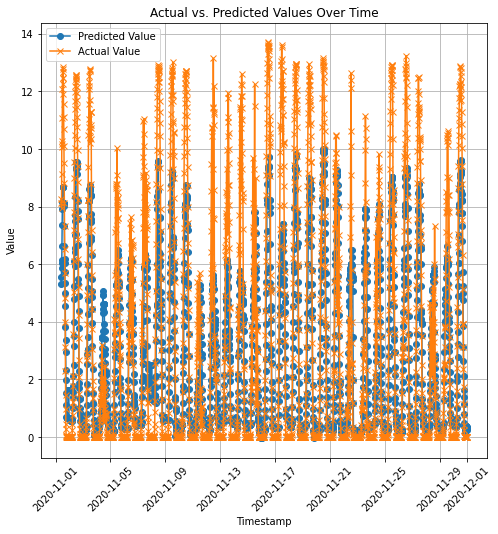

In [639]:
plt.figure(figsize=(8, 8))
plt.plot(results.index, results2['Predicted'], label='Predicted Value', marker='o')
plt.plot(results.index, results2['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Solar 3

In [648]:
Solar3 = df.drop(columns=['Solar0','Solar1','Solar2','Solar4','Solar5'])
Solar3

,Date,Solar3
0,2016-07-04 07:30:00,NaN
1,2016-07-04 07:45:00,NaN
2,2016-07-04 08:00:00,NaN
3,2016-07-04 08:15:00,NaN
4,2016-07-04 08:30:00,NaN
...,...,...
151781,2020-11-01 08:45:00,4.31
151782,2020-11-01 09:00:00,5.08
151783,2020-11-01 09:15:00,5.45
151784,2020-11-01 09:30:00,5.83


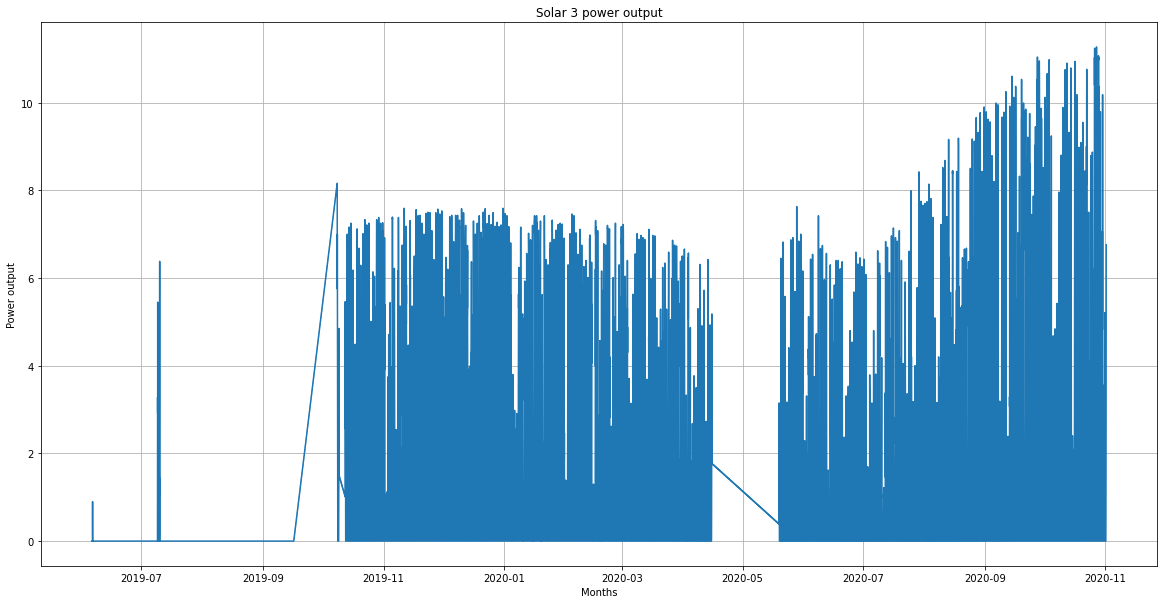

In [649]:
plt.figure(figsize=(20, 10))
plt.plot(Solar3['Date'], Solar3['Solar3'])
plt.xlabel('Months')
plt.ylabel('Power output')
plt.title('Solar 3 power output')
plt.grid(True)
plt.show()

In [650]:
Solar3.set_index('Date', inplace=True)
s = Solar3.index > '2019-09-30 23:49:00'
t = Solar3.index < '2020-11-01 00:00:00'
Solar3 = Solar3[s&t]
Solar3

,Solar3
Date,
2019-10-01 00:00:00,5.39
2019-10-01 00:15:00,5.39
2019-10-01 00:30:00,5.39
2019-10-01 00:45:00,5.40
2019-10-01 01:00:00,5.40
...,...
2020-10-31 22:45:00,0.00
2020-10-31 23:00:00,0.00
2020-10-31 23:15:00,0.00


In [651]:
weather = pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
s = weather.index > '2019-09-30 23:49:00'
weather3 = weather[s]
weather3

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2019-10-01 00:00:00,6.600,4.400,2.100,103031.800,0.900,0.000,260.300,0.1
2019-10-01 00:15:00,6.400,4.325,2.075,103022.500,0.900,0.000,260.025,0.1
2019-10-01 00:30:00,6.200,4.250,2.050,103013.200,0.900,0.000,259.750,0.1
2019-10-01 00:45:00,6.000,4.175,2.025,103003.900,0.900,0.000,259.475,0.1
2019-10-01 01:00:00,5.800,4.100,2.000,102994.600,0.900,0.000,259.200,0.1
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.200,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.500,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.800,1.0


In [652]:
nov_data = pd.read_csv('NOV_test_data.csv')
nov_data = nov_data.iloc[:, 1:]
nov_data['Date'] = pd.to_datetime(nov_data['Date'])
nov_data = nov_data.drop(columns=['Building0','Building1','Building3','Building4','Building5','Building6','Solar5','Solar0','Solar1','Solar2','Solar4'])
nov_data.set_index('Date', inplace=True)
t = nov_data.index < '2020-12-01 00:00:00'
nov_data3 = nov_data[t]
nov_data3

,Solar3
Date,
2020-11-01 10:00:00,7.69
2020-11-01 10:15:00,7.52
2020-11-01 10:30:00,7.35
2020-11-01 10:45:00,8.15
2020-11-01 11:00:00,8.96
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# Y - train (Solar 3)

In [653]:
Solar3

,Solar3
Date,
2019-10-01 00:00:00,5.39
2019-10-01 00:15:00,5.39
2019-10-01 00:30:00,5.39
2019-10-01 00:45:00,5.40
2019-10-01 01:00:00,5.40
...,...
2020-10-31 22:45:00,0.00
2020-10-31 23:00:00,0.00
2020-10-31 23:15:00,0.00


# Y - test

In [654]:
nov_data3

,Solar3
Date,
2020-11-01 10:00:00,7.69
2020-11-01 10:15:00,7.52
2020-11-01 10:30:00,7.35
2020-11-01 10:45:00,8.15
2020-11-01 11:00:00,8.96
...,...
2020-11-30 22:45:00,0.00
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00


# X - train

In [655]:
'''
* Surface  Thermal Radiation
* Surface Solar Radiation
* MSLP
* Dew Point Temperature
* Air Temperature
'''

t = weather3.index < '2020-11-01 00:00:00'
weather_train3 = weather3[t]
weather_train3 = weather_train3[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_train3

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2019-10-01 00:00:00,260.300,0.0,103031.800,4.400,6.60
2019-10-01 00:15:00,260.025,0.0,103022.500,4.325,6.40
2019-10-01 00:30:00,259.750,0.0,103013.200,4.250,6.20
2019-10-01 00:45:00,259.475,0.0,103003.900,4.175,6.00
2019-10-01 01:00:00,259.200,0.0,102994.600,4.100,5.80
...,...,...,...,...,...
2020-10-31 22:45:00,336.375,0.0,101948.875,9.375,12.05
2020-10-31 23:00:00,332.000,0.0,101948.000,9.300,12.00
2020-10-31 23:15:00,330.850,0.0,101959.000,9.250,11.95


# X - test

In [656]:
s = weather3.index >= '2020-11-01 10:00:00'
t = weather3.index < '2020-12-01 00:00:00'
weather_test3 = weather3[s&t]
weather_test3 = weather_test3[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
weather_test3

,surface_thermal_radiation (W/m^2),surface_solar_radiation (W/m^2),mean_sea_level_pressure (Pa),dewpoint_temperature (degC),temperature (degC)
timestamp,,,,,
2020-11-01 10:00:00,355.400,497.60,102398.800,9.300,14.400
2020-11-01 10:15:00,353.825,544.05,102398.025,9.400,14.750
2020-11-01 10:30:00,352.250,590.50,102397.250,9.500,15.100
2020-11-01 10:45:00,350.675,636.95,102396.475,9.600,15.450
2020-11-01 11:00:00,349.100,683.40,102395.700,9.700,15.800
...,...,...,...,...,...
2020-11-30 22:45:00,357.950,0.00,100671.375,15.575,18.875
2020-11-30 23:00:00,357.300,0.00,100667.600,15.600,18.700
2020-11-30 23:15:00,356.000,0.00,100633.300,15.550,18.625


In [658]:
X_train3 = weather_train3
X_train3 = (X_train3-X_train3.mean())/X_train3.std()

In [659]:
X_test3 = weather_test3
X_test3 = (X_test3-X_test3.mean())/X_test3.std()

In [660]:
Y_train3 = Solar3['Solar3']
Y_test3 = nov_data3['Solar3']

In [661]:
print('X_train:',X_train3.shape)
print('X_test:',X_test3.shape)
print('Y_train:',Y_train3.shape)
print('Y_test:',Y_test3.shape)

X_train: (38112, 5)
X_test: (2840, 5)
Y_train: (38112,)
Y_test: (2840,)


In [662]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specify the objective for regression
    n_estimators=300,  # Number of boosting rounds
    learning_rate=0.03,  # Learning rate (step size)
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Random seed for reproducibility
)

regressor.fit(X_train3, Y_train3)
predictions3 = regressor.predict(X_test3)

MSE = mean_squared_error(Y_test3, predictions3)
print("MSE:", MSE)

total = np.sum((Y_test3 - np.mean(Y_test3))**2)
residual = np.sum((Y_test3 - predictions3)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 4.962766951540577
R^2: 0.6616373284350419


In [663]:
results3 = pd.DataFrame({'Actual': Y_test3, 'Predicted': predictions3})
results3

,Actual,Predicted
Date,,
2020-11-01 10:00:00,7.69,4.629716
2020-11-01 10:15:00,7.52,4.812749
2020-11-01 10:30:00,7.35,4.939950
2020-11-01 10:45:00,8.15,4.982503
2020-11-01 11:00:00,8.96,5.084332
...,...,...
2020-11-30 22:45:00,0.00,0.212610
2020-11-30 23:00:00,0.00,0.212610
2020-11-30 23:15:00,0.00,0.215739


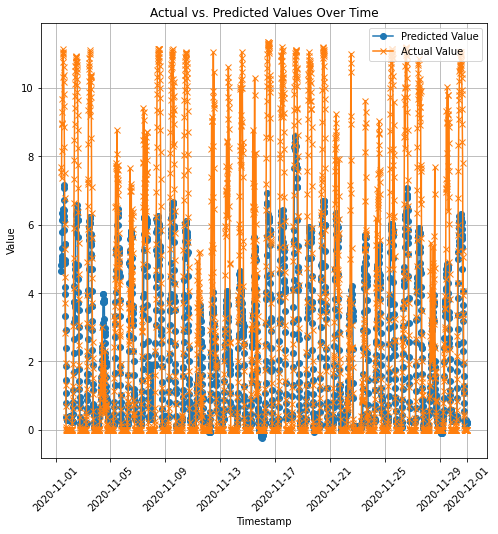

In [664]:
plt.figure(figsize=(8, 8))
plt.plot(results.index, results3['Predicted'], label='Predicted Value', marker='o')
plt.plot(results.index, results3['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()